# Cyclist Inclusion Analysis

In this notebook we analyze how friendly of a city Toronto is for cyclists. The city of Toronto (https://www.toronto.ca/) provides a wealth of excellent datasets which we will use in this project. The general idea is to conceptualize the city as a graph with nodes and edges connecting the nodes. We supply some a priori structure to this conceptualization: 

1) Addresses serve as nodes of departure (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/)
2) The bikeways serve as the edges (https://open.toronto.ca/dataset/bikeways/)
3) Various other data sets of interest serve as destination nodes, e.g. bike parking, air conditioned and cool spaces, and trail entrances.

## Import Packages and Libraries, Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import LineString

### Bikeways

In [2]:
# Bring in the bikeways data in shapefile format https://open.toronto.ca/dataset/bikeways/
bikeways = gpd.read_file('raw_data/Bike network data.shp')

In [3]:
bikeways.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,...,FIELD_19,FIELD_20,FIELD_21,FIELD_22,FIELD_23,FIELD_24,FIELD_25,FIELD_26,FIELD_27,geometry
0,12837,2669,None,2001,2021,None,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,None,...,None,Sharrows - Wayfinding,None,None,None,None,None,Converted in 2007,128.045211,"LINESTRING (-79.40351 43.69526, -79.40309 43.6..."
1,12838,2670,None,2001,2009,None,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,None,...,None,Multi-Use Trail,None,None,None,None,None,None,128.686230,"LINESTRING (-79.40364 43.63499, -79.40355 43.6..."
2,12839,2671,None,2001,2011,None,Gatineau Hydro Corridor Trl,Givendale Rd,Kennedy Rd,None,...,None,Multi-Use Trail,None,None,None,None,None,None,379.789303,"LINESTRING (-79.27522 43.74158, -79.27518 43.7..."
3,12840,2672,None,2001,2011,None,G Ross Lord Park Trl,Dufferin St,G Ross Lord Park Trl Branch,None,...,None,Multi-Use Trail,None,None,None,None,None,None,552.499431,"LINESTRING (-79.46772 43.77208, -79.46759 43.7..."
4,12841,2673,None,2001,2012,None,Etobicoke Creek Trl,Etobicoke Creek Trl Branch,Forty Third St,None,...,None,Multi-Use Trail - Entrance,None,None,None,None,None,None,152.152899,"LINESTRING (-79.54812 43.59027, -79.54807 43.5..."


In [4]:
# Column names didn't make it in. Bring in the csv version of the same data to get the correct column names
df = pd.read_csv('raw_data/Bike network data - 4326.csv')

In [5]:
df.head()

,_id,OBJECTID,SEGMENT_ID,INSTALLED,UPGRADED,PRE_AMALGAMATION,STREET_NAME,FROM_STREET,TO_STREET,ROADCLASS,...,DIR_HIGHORDER,INFRA_HIGHORDER,SEPA_HIGHORDER,SEPB_HIGHORDER,ORIG_HIGHORDER,BYLAWED,LAST_EDIT_DATE,UPGRADE_DESCRIPTION,Shape__Length,geometry
0,12837,2669,NaN,2001,2021,NaN,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,NaN,...,NaN,Sharrows - Wayfinding,NaN,NaN,NaN,NaN,NaN,Converted in 2007,128.045211,"{'type': 'MultiLineString', 'coordinates': (((..."
1,12838,2670,NaN,2001,2009,NaN,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,NaN,...,NaN,Multi-Use Trail,NaN,NaN,NaN,NaN,NaN,NaN,128.686230,"{'type': 'MultiLineString', 'coordinates': (((..."
2,12839,2671,NaN,2001,2011,NaN,Gatineau Hydro Corridor Trl,Givendale Rd,Kennedy Rd,NaN,...,NaN,Multi-Use Trail,NaN,NaN,NaN,NaN,NaN,NaN,379.789303,"{'type': 'MultiLineString', 'coordinates': (((..."
3,12840,2672,NaN,2001,2011,NaN,G Ross Lord Park Trl,Dufferin St,G Ross Lord Park Trl Branch,NaN,...,NaN,Multi-Use Trail,NaN,NaN,NaN,NaN,NaN,NaN,552.499431,"{'type': 'MultiLineString', 'coordinates': (((..."
4,12841,2673,NaN,2001,2012,NaN,Etobicoke Creek Trl,Etobicoke Creek Trl Branch,Forty Third St,NaN,...,NaN,Multi-Use Trail - Entrance,NaN,NaN,NaN,NaN,NaN,NaN,152.152899,"{'type': 'MultiLineString', 'coordinates': (((..."


In [6]:
# Replace all shapefile column names with csv column names
shp_names = list(bikeways.columns)
csv_names = list(df.columns)
mapper = dict(zip(shp_names, csv_names))
bikeways.rename(mapper = mapper, axis = 1, inplace = True)
bikeways.head(2)

,_id,OBJECTID,SEGMENT_ID,INSTALLED,UPGRADED,PRE_AMALGAMATION,STREET_NAME,FROM_STREET,TO_STREET,ROADCLASS,...,DIR_HIGHORDER,INFRA_HIGHORDER,SEPA_HIGHORDER,SEPB_HIGHORDER,ORIG_HIGHORDER,BYLAWED,LAST_EDIT_DATE,UPGRADE_DESCRIPTION,Shape__Length,geometry
0,12837,2669,None,2001,2021,None,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,None,...,None,Sharrows - Wayfinding,None,None,None,None,None,Converted in 2007,128.045211,"LINESTRING (-79.40351 43.69526, -79.40309 43.6..."
1,12838,2670,None,2001,2009,None,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,None,...,None,Multi-Use Trail,None,None,None,None,None,None,128.686230,"LINESTRING (-79.40364 43.63499, -79.40355 43.6..."


In [7]:
bikeways.shape

(1334, 28)

In [8]:
bikeways.isna().sum()

_id                       0
OBJECTID                  0
SEGMENT_ID             1334
INSTALLED                 0
UPGRADED                  0
PRE_AMALGAMATION       1334
STREET_NAME               0
FROM_STREET               9
TO_STREET                11
ROADCLASS              1334
CNPCLASS               1334
SURFACE                1334
OWNER                  1334
DIR_LOWORDER           1334
INFRA_LOWORDER           97
SEPA_LOWORDER          1334
SEPB_LOWORDER          1334
ORIG_LOWORDER_INFRA    1334
DIR_HIGHORDER          1334
INFRA_HIGHORDER           1
SEPA_HIGHORDER         1334
SEPB_HIGHORDER         1334
ORIG_HIGHORDER         1334
BYLAWED                1334
LAST_EDIT_DATE         1334
UPGRADE_DESCRIPTION    1297
Shape__Length             0
geometry                  0
dtype: int64

In [9]:
# Drop the columns with more than 90% missing values
for i in bikeways.columns:
    if bikeways[i].isna().sum() > len(bikeways) * 0.9: 
        bikeways.drop(columns = i, inplace = True)

# make column names lower case
bikeways.columns = map(str.lower, bikeways.columns)
bikeways.head()

,_id,objectid,installed,upgraded,street_name,from_street,to_street,infra_loworder,infra_highorder,shape__length,geometry
0,12837,2669,2001,2021,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,Sharrows - Wayfinding,Sharrows - Wayfinding,128.045211,"LINESTRING (-79.40351 43.69526, -79.40309 43.6..."
1,12838,2670,2001,2009,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,Multi-Use Trail,Multi-Use Trail,128.686230,"LINESTRING (-79.40364 43.63499, -79.40355 43.6..."
2,12839,2671,2001,2011,Gatineau Hydro Corridor Trl,Givendale Rd,Kennedy Rd,Multi-Use Trail,Multi-Use Trail,379.789303,"LINESTRING (-79.27522 43.74158, -79.27518 43.7..."
3,12840,2672,2001,2011,G Ross Lord Park Trl,Dufferin St,G Ross Lord Park Trl Branch,Multi-Use Trail,Multi-Use Trail,552.499431,"LINESTRING (-79.46772 43.77208, -79.46759 43.7..."
4,12841,2673,2001,2012,Etobicoke Creek Trl,Etobicoke Creek Trl Branch,Forty Third St,Multi-Use Trail - Entrance,Multi-Use Trail - Entrance,152.152899,"LINESTRING (-79.54812 43.59027, -79.54807 43.5..."


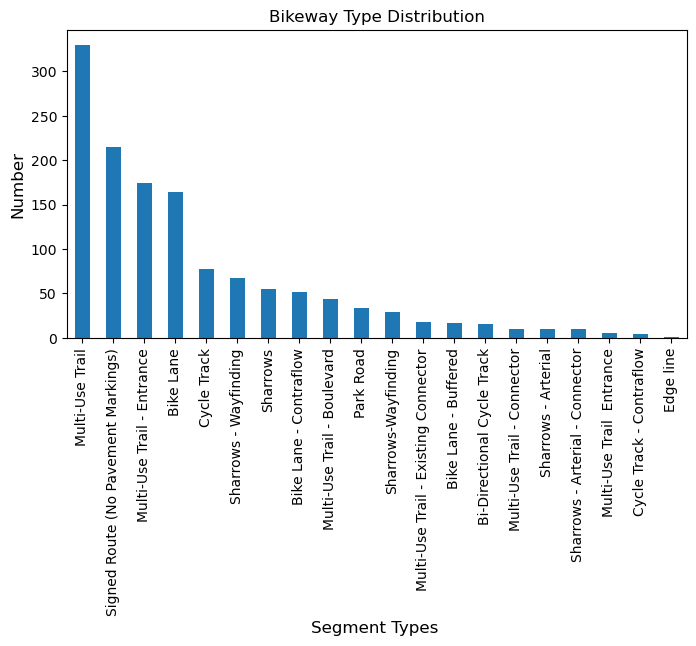

In [10]:
# infra_highorder and infra_loworder refer to the highest and lowest classified cycling infrastructure type installed 
# on each segment, respectively. 

plt.figure(figsize=(8,4))
plt.title("Bikeway Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Segment Types ', fontsize=12)

bikeways.infra_highorder.value_counts().plot.bar()
plt.show()

In [11]:
# Check coordinate reference system
bikeways.crs

{'init': 'epsg:4326'}

In [12]:
# epsg:2019 is a great crs for Toronto. Change crs to epsg:2019
bikeways = bikeways.to_crs({'init': 'epsg:2019'})

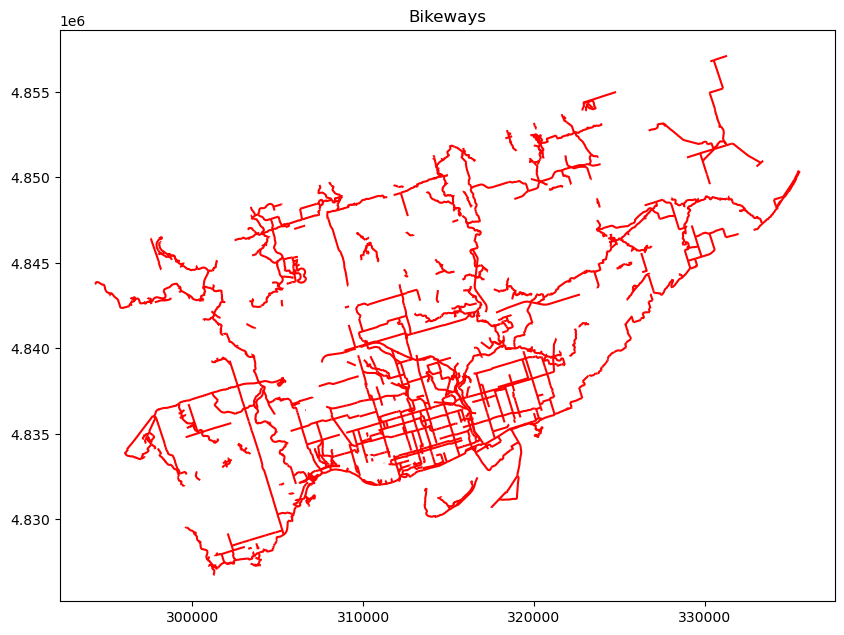

In [13]:
# plot the bike network. the shapely objects in the geometry column are lines
ax = bikeways.plot(figsize=(10, 10), color='red', markersize = 1)
ax.set_title('Bikeways')
plt.show()

In [14]:
# # Isolate the longitude and lattitude numbers into x and y respectively
# bike_network['x'] = bike_network.geometry.x
# bike_network['y'] = bike_network.geometry.y
# bike_network.head()

# Looking at the Bike Parking

In [15]:
# Read in dataset of bicycle parking locations
bike_parking = gpd.read_file('raw_data/Street furniture-Bicycle parking data.shp')
bike_parking.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry
0,1,23,BP-11338,1495,Queen St W,None,None,Dowling Ave,None,None,04,Parkdale Village,None,Existing,None,POINT (-79.44025 43.63981)
1,2,32,BP-03501,8,Kensington Ave,None,None,Kensington Ave,None,None,11,Kensington Market,Ring,Existing,None,POINT (-79.40013 43.65306)
2,3,35,BP-11699,70,The Pond Rd,None,None,Seneca Lane,None,None,07,None,Rack,Existing,None,POINT (-79.49983 43.77077)
3,4,107,BP-12883,21,Canniff St,None,None,Strachan Ave,None,None,10,None,Ring,Existing,None,POINT (-79.41149 43.64145)
4,5,176,BP-15966,87,Avenue Rd,Avenue Rd,East,Elgin Ave,North,None,11,None,Ring,Existing,None,POINT (-79.39534 43.67200)


In [16]:
# Correct column names didn't make it in
bike_parking.columns

Index(['FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6',
       'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12',
       'FIELD_13', 'FIELD_14', 'FIELD_15', 'geometry'],
      dtype='object')

In [17]:
# Read in csv of proper column names
c_names = pd.read_csv('raw_data/Street furniture-Bicycle parking data_fields.csv')
c_names

,field,name
0,FIELD_1,_id
1,FIELD_2,OBJECTID
2,FIELD_3,ID
3,FIELD_4,ADDRESSNUMBERTEXT
4,FIELD_5,ADDRESSSTREET
5,FIELD_6,FRONTINGSTREET
6,FIELD_7,SIDE
7,FIELD_8,FROMSTREET
8,FIELD_9,DIRECTION
9,FIELD_10,SITEID


In [18]:
# Replace wrong names with right names
wrong_names = list(bike_parking.columns)
right_names = c_names['name']
mapper = dict(zip(wrong_names, right_names))

bike_parking.rename(mapper = mapper, axis = 1, inplace = True)
bike_parking.head()

,_id,OBJECTID,ID,ADDRESSNUMBERTEXT,ADDRESSSTREET,FRONTINGSTREET,SIDE,FROMSTREET,DIRECTION,SITEID,WARD,BIA,ASSETTYPE,STATUS,SDE_STATE_ID,geometry
0,1,23,BP-11338,1495,Queen St W,None,None,Dowling Ave,None,None,04,Parkdale Village,None,Existing,None,POINT (-79.44025 43.63981)
1,2,32,BP-03501,8,Kensington Ave,None,None,Kensington Ave,None,None,11,Kensington Market,Ring,Existing,None,POINT (-79.40013 43.65306)
2,3,35,BP-11699,70,The Pond Rd,None,None,Seneca Lane,None,None,07,None,Rack,Existing,None,POINT (-79.49983 43.77077)
3,4,107,BP-12883,21,Canniff St,None,None,Strachan Ave,None,None,10,None,Ring,Existing,None,POINT (-79.41149 43.64145)
4,5,176,BP-15966,87,Avenue Rd,Avenue Rd,East,Elgin Ave,North,None,11,None,Ring,Existing,None,POINT (-79.39534 43.67200)


In [19]:
len(bike_parking)

17328

In [20]:
bike_parking.isna().sum()

_id                      0
OBJECTID                 0
ID                       0
ADDRESSNUMBERTEXT        0
ADDRESSSTREET            0
FRONTINGSTREET           0
SIDE                     0
FROMSTREET               0
DIRECTION                0
SITEID                   0
WARD                     0
BIA                      0
ASSETTYPE                0
STATUS                   0
SDE_STATE_ID         17328
geometry                 0
dtype: int64

In [21]:
# Drop SD_STATE_ID column; it has no valid values
bike_parking.drop(columns = ['SDE_STATE_ID'], inplace = True)

In [22]:
bike_parking.crs

{'init': 'epsg:4326'}

In [23]:
# As always, reproject to preferred crs
bike_parking = bike_parking.to_crs({'init': 'epsg:2019'})
bike_parking.crs

{'init': 'epsg:2019'}

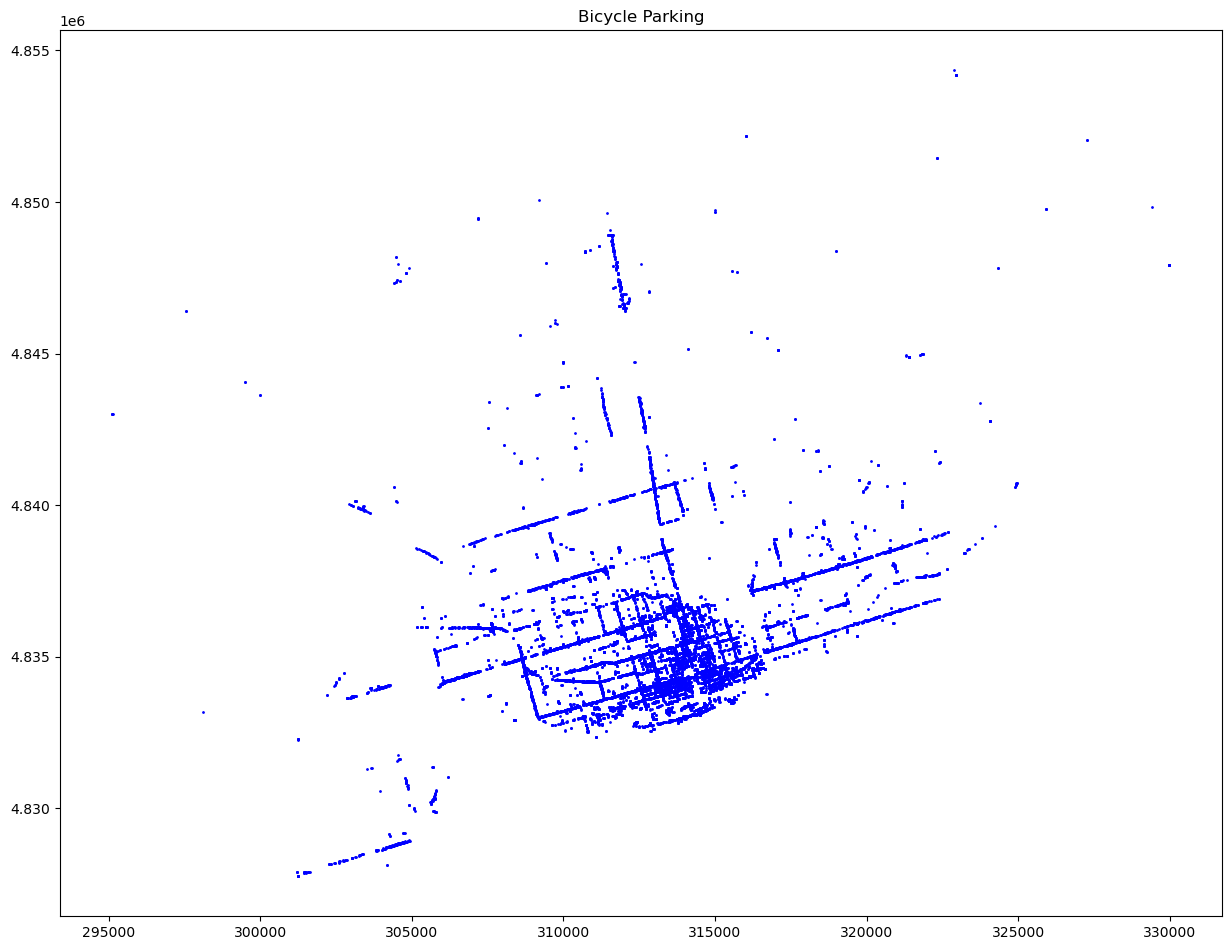

In [24]:
# Plotting the bike parking
ax = bike_parking.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Bicycle Parking')
plt.show()

### Toronto Addresses

In [25]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# The One Address Repository data set provides a point representation for over 500,000 addresses within the City of Toronto.
address = gpd.read_file('raw_data/ADDRESS_POINT_WGS84.shp')
address.head()

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LO_NUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,...,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry
0,5729529,5729516,REGULAR,399,Lake Promenade,399,None,NaN,None,L,...,Land,None,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854300.947 5401738.297)
1,9950585,9950578,REGULAR,7,Hilo Rd,7,None,NaN,None,L,...,Land,None,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854393.601 5401944.461)
2,5729496,5729468,REGULAR,387,Lake Promenade,387,None,NaN,None,L,...,Land,None,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854243.981 5401777.244)
3,5729341,5729332,REGULAR,321,Lake Promenade,321,None,NaN,None,L,...,Land,None,301926.249,4827620.088,-79.535591,43.588517,1491594.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853861.166 5401982.195)
4,7304577,7304570,REGULAR,22,Thirty Sixth St,22,None,NaN,None,L,...,Land,None,301937.384,4827737.920,-79.535454,43.589578,1491597.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853845.885 5402145.216)


In [26]:
# That's a lot of columns. Many of these will be irrelevant for us
address.columns

Index(['GEO_ID', 'LINK', 'MAINT_STAG', 'ADDRESS', 'LFNAME', 'LO_NUM',
       'LONUMSUF', 'HINUM', 'HINUMSUF', 'ARC_SIDE', 'DISTANCE', 'FCODE',
       'FCODE_DES', 'CLASS', 'NAME', 'X', 'Y', 'LONGITUDE', 'LATITUDE',
       'OBJECTID', 'MUN_NAME', 'WARD_NAME', 'geometry'],
      dtype='object')

In [27]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

# Keep only columns that we may need.
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid',
                   'mun_name','ward_name','geometry']]
address.head()

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,ward_name,geometry
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854300.947 5401738.297)
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854393.601 5401944.461)
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854243.981 5401777.244)
3,5729341,REGULAR,321,Lake Promenade,301926.249,4827620.088,-79.535591,43.588517,1491594.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853861.166 5401982.195)
4,7304577,REGULAR,22,Thirty Sixth St,301937.384,4827737.920,-79.535454,43.589578,1491597.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853845.885 5402145.216)


In [28]:
# All CRS should agree with each other
bikeways['geometry'].crs, address['geometry'].crs

({'init': 'epsg:2019'}, {'init': 'epsg:3857'})

In [29]:
# reprojecting epsg 3857 to epsg 2019
address = address.to_crs({'init': 'epsg:2019'})

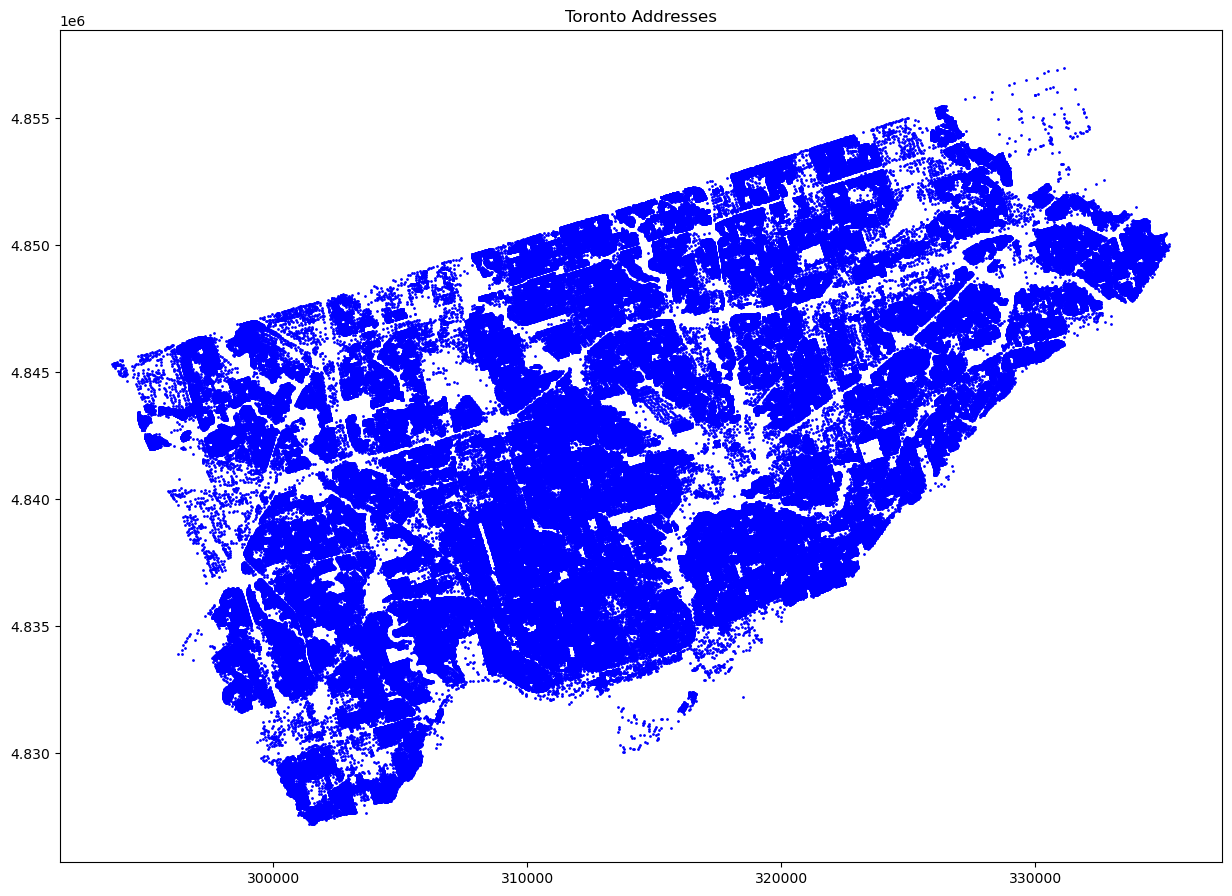

In [30]:
# Plotting the Addresses
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses')
plt.show()

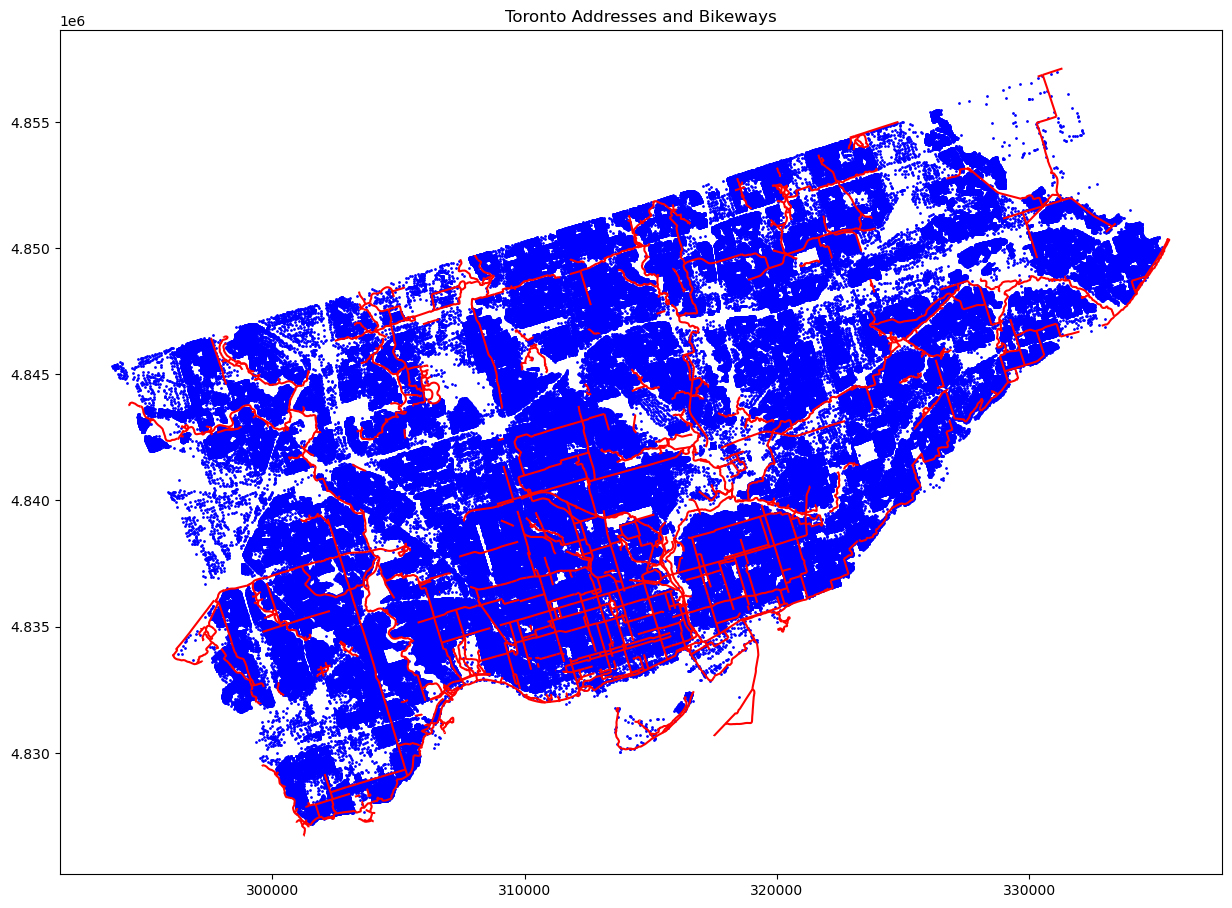

In [31]:
# Plotting the Addresses and Bikeways together
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
bikeways.plot(ax=ax,color='red', markersize =10)
ax.set_title('Toronto Addresses and Bikeways')
plt.show()

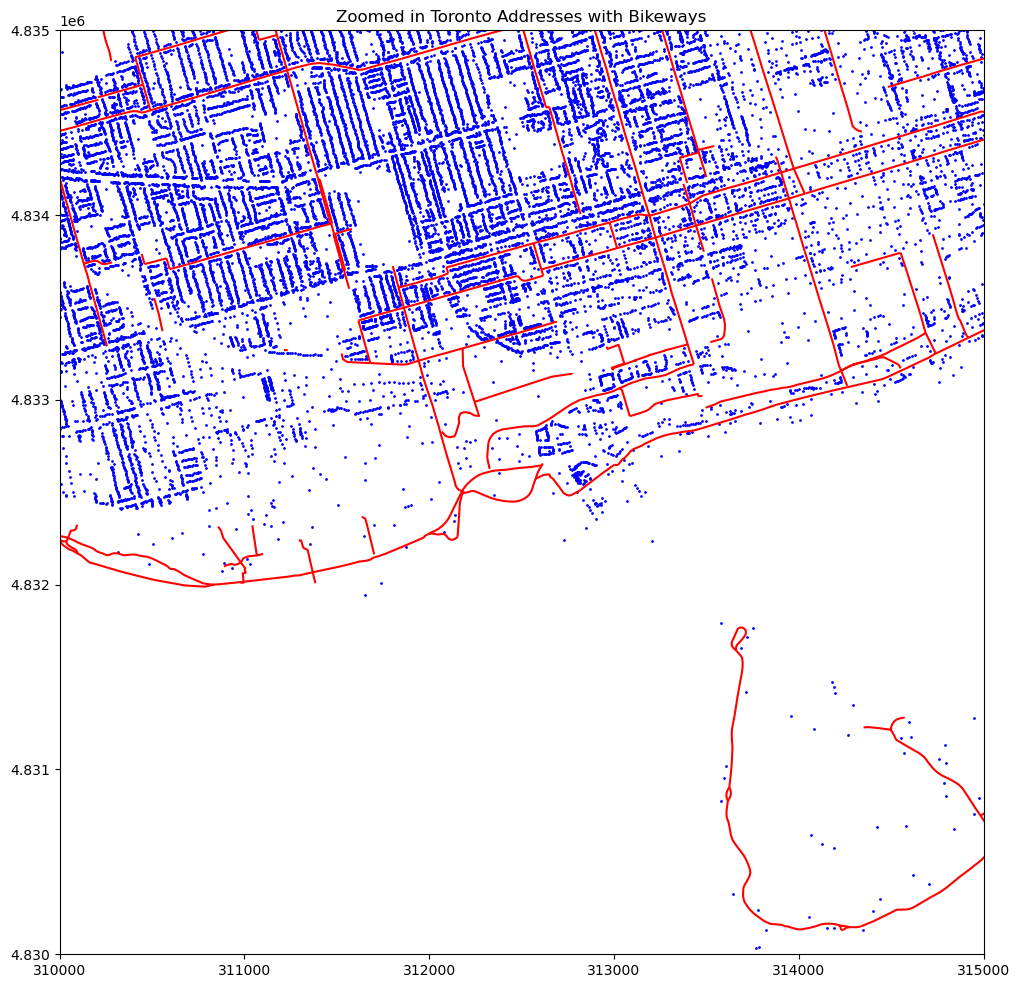

In [32]:
# Check out a zoomed in portion of the addresses with bikeways
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
bikeways.plot(ax=ax,color='red', markersize =10)
ax.set(xlim=(310000, 315000), ylim=(4830000, 4835000))
ax.set_title('Zoomed in Toronto Addresses with Bikeways')
plt.show()

In [33]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

In [34]:
# Unpack geometry coordinates in bike network
bikeways = bikeways.explode()
bikeways.head(2)

,,_id,objectid,installed,upgraded,street_name,from_street,to_street,infra_loworder,infra_highorder,shape__length,geometry
0,0,12837,2669,2001,2021,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,Sharrows - Wayfinding,Sharrows - Wayfinding,128.045211,"LINESTRING (312578.291 4839267.496, 312611.526..."
1,0,12838,2670,2001,2009,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,Multi-Use Trail,Multi-Use Trail,128.686230,"LINESTRING (312575.443 4832572.361, 312582.781..."


In [35]:
graph = create_graph(bikeways)

In [36]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(graph,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [37]:
# Assigning node ids to to_node and from_node
nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges.head(3)

,from,to,geometry,to_street,forward,_id,infra_loworder,infra_highorder,installed,shape__length,from_street,upgraded,length,visited,objectid,street_name,to_node,from_node
0,"(312578.291, 4839267.496)","(312667.201, 4839293.709)",LINESTRING (312578.2909386895 4839267.49634173...,Oriole Pkwy,1,12837,Sharrows - Wayfinding,Sharrows - Wayfinding,2001,128.045211,Highbourne Rd,2021,92.695066,0,2669,Kilbarry Rd,1436,571
1,"(312578.291, 4839267.496)","(312201.057, 4839160.708)",LINESTRING (312201.0571219128 4839160.70845240...,Highbourne Rd,1,13442,Sharrows - Wayfinding,Sharrows - Wayfinding,2005,541.555846,Dunvegan Rd,2021,392.057474,0,3274,Kilbarry Rd,345,571
2,"(312667.201, 4839293.709)","(312867.049, 4839347.147)",LINESTRING (312667.2014882197 4839293.70906910...,Lascelles Blvd,1,13844,Sharrows - Wayfinding,Sharrows - Wayfinding,2005,285.748308,Oriole Pkey,2021,206.868741,0,3676,Kilbarry Rd,183,1436


# Creating the Pandana Network

In [38]:
bike_net = pdna.Network(nodes["x"], 
                        nodes["y"],
                        edges["from_node"],
                        edges["to_node"],
                        pd.DataFrame([edges['length']]).T,
                        twoway=True)

In [39]:
#precompute a given horizon distance of 1000 meters
bike_net.precompute(1000)
bike_net.edges_df.head(2)

,from,to,length
0,571,1436,92.695066
1,571,345,392.057474


In [44]:
#get node_ids for points for each layer
x, y = bike_parking['geometry'].x, bike_parking['geometry'].y 
bike_parking["node_ids"] = bike_net.get_node_ids(x, y)
bike_net.set(bike_parking["node_ids"], name="parking_location")

In [46]:
#get nearest points with id
# 10km is chosen as a max distance, as opposed to the 5k for walking
n=10
maxdistance = 10000

bike_net.set_pois("parking_area", maxdistance , n, bike_parking['geometry'].x, bike_parking['geometry'].y)
bike_network_bike_distances = bike_net.nearest_pois(maxdistance , "parking_area", num_pois=n, include_poi_ids=False)

bike_network_bike_distances.head(3)

,1,2,3,4,5,6,7,8,9,10
0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
1,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
2,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046,1628.722046


In [48]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['parking_area'+str(i) for i in range(0,n,1)]

bike_network_bike_distances.columns = columns
bike_network_bike_distances.head(2)

,parking_area0,parking_area1,parking_area2,parking_area3,parking_area4,parking_area5,parking_area6,parking_area7,parking_area8,parking_area9
0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [49]:
bike_network_bike_distances.shape

(1983, 10)

In [51]:
for i in range(10):
    address['d_parking_area{}'.format(i)]=bike_parking['node_ids'].map(bike_network_bike_distances['parking_area{}'.format(i)])
address.head(3)

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,d_parking_area0,d_parking_area1,d_parking_area2,d_parking_area3,d_parking_area4,d_parking_area5,d_parking_area6,d_parking_area7,d_parking_area8,d_parking_area9
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
address.columns

Index(['geo_id', 'maint_stag', 'address', 'lfname', 'x', 'y', 'longitude',
       'latitude', 'objectid', 'mun_name', 'ward_name', 'geometry',
       'd_parking_area0', 'd_parking_area1', 'd_parking_area2',
       'd_parking_area3', 'd_parking_area4', 'd_parking_area5',
       'd_parking_area6', 'd_parking_area7', 'd_parking_area8',
       'd_parking_area9'],
      dtype='object')

#### Calculate minutes fields based on distances
We are applying an average cycling speed of 15km/h

15km/h(1h/60min)(1000m/1km) = 250m/min

In [53]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_bike_path_0'] = address.apply(lambda row: row.d_parking_area0/(250), axis=1)
address['m_bike_path_1'] = address.apply(lambda row: row.d_parking_area1/(250), axis=1)
address['m_bike_path_2'] = address.apply(lambda row: row.d_parking_area2/(250), axis=1)
address['m_bike_path_3'] = address.apply(lambda row: row.d_parking_area3/(250), axis=1)
address['m_bike_path_4'] = address.apply(lambda row: row.d_parking_area4/(250), axis=1)
address['m_bike_path_5'] = address.apply(lambda row: row.d_parking_area5/(250), axis=1)
address['m_bike_path_6'] = address.apply(lambda row: row.d_parking_area6/(250), axis=1)
address['m_bike_path_7'] = address.apply(lambda row: row.d_parking_area7/(250), axis=1)
address['m_bike_path_8'] = address.apply(lambda row: row.d_parking_area8/(250), axis=1)
address['m_bike_path_9'] = address.apply(lambda row: row.d_parking_area9/(250), axis=1)
address.head(3)

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,m_bike_path_0,m_bike_path_1,m_bike_path_2,m_bike_path_3,m_bike_path_4,m_bike_path_5,m_bike_path_6,m_bike_path_7,m_bike_path_8,m_bike_path_9
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\metal\anaconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\metal\anaconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Text(0.5, 1.0, 'Walking Times To Closest Bike Path')

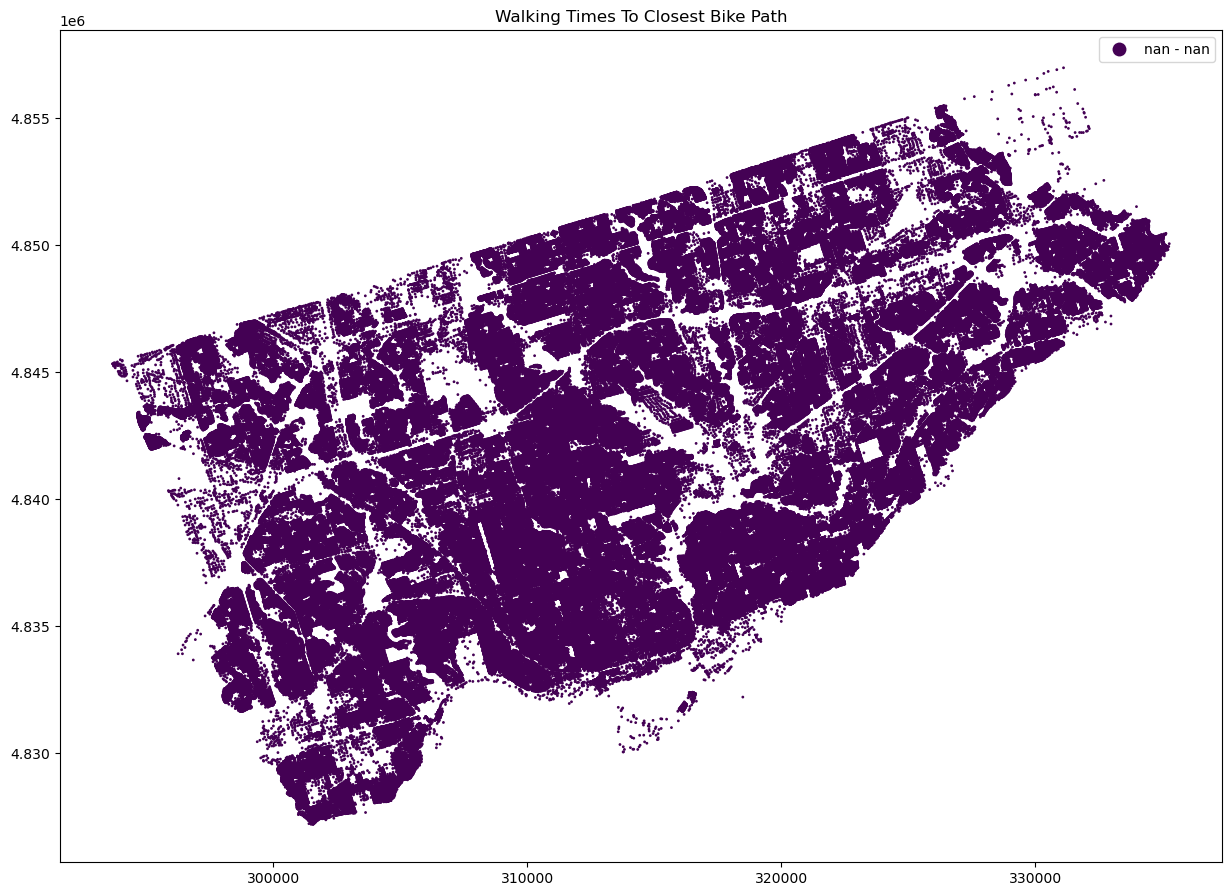

In [54]:
# Walking times To closest TTC Stop with TTC stops added

ax = address.plot(figsize=(15, 15), column='m_bike_path_0', scheme='quantiles', legend=True,markersize = 1)
# child_care.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest Bike Path')
plt.show()